# Zeno Tutor MM RAG with Langchain

## Data Loading
- Partition PDF tables, text, and images
- Use Unstructured to partition elements

In [63]:
from unstructured.partition.pdf import partition_pdf
import os

try:
    print("Starting PDF processing...")
    
    # Verify input file exists
    input_pdf = "textbook_input/test.pdf"
    if not os.path.exists(input_pdf):
        raise FileNotFoundError(f"Input PDF file not found: {input_pdf}")
    
    # Verify output directory exists, create if not
    image_path="textbook_output/"
    if not os.path.exists(image_path):
        print(f"Creating output directory: {image_path}")
        os.makedirs(image_path)
    
    print("Extracting content from PDF...")
    raw_pdf_elements = partition_pdf(
        input_pdf,
        chunking_strategy="by_title",
        extract_images_in_pdf=True,
        infer_table_structure=True,
        languages=["eng"],
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=image_path
    )
    
    print(f"PDF processing completed. Found {len(pdf_elements)} elements.")

except FileNotFoundError as e:
    print(f"Error: {e}")
except PermissionError:
    print(f"Error: Permission denied accessing the input file or output directory")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")

Starting PDF processing...
Extracting content from PDF...
PDF processing completed. Found 2 elements.


In [64]:
import shutil

figures_path = "figures"
if os.path.exists(figures_path):
    for filename in os.listdir(figures_path):
        shutil.move(os.path.join(figures_path, filename), image_path)
    os.rmdir(figures_path)

In [65]:
for element in raw_pdf_elements:
    print(element)

2.1 * Solve Equations Using the Subtraction and Addition Properties of Equality 191

[>] TRYIT 22 Is y = 2 a solution of Sy + 3 = 10y —4?

Solve Equations Using the Subtraction and Addition Properties of Equality

We are going to use a model to clarify the process of solving an equation. An envelope represents the variable - since its contents are unknown - and each counter represents one. We will set out one envelope and some counters on our workspace, as shown in Figure 2.2. Both sides of the workspace have the same number of counters, but some counters are “hidden” in the envelope. Can you tell how many counters are in the envelope?

0° oO @@ | @@ ©) ©)

Figure 2.2 The illustration shows a model of an equation with one variable. On the left side of the workspace is an unknown (envelope) and three counters, while on the right side of the workspace are eight counters.

What are you thinking? What steps are you taking in your mind to figure out how many counters are in the envelope?

P

In [66]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 2}

In [54]:
from langchain_text_splitters import CharacterTextSplitter

# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables

# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)
texts_4k_token

["2.1 * Solve Equations Using the Subtraction and Addition Properties of Equality 191\n\n[>] TRYIT 22 Is y = 2 a solution of Sy + 3 = 10y —4?\n\nSolve Equations Using the Subtraction and Addition Properties of Equality\n\nWe are going to use a model to clarify the process of solving an equation. An envelope represents the variable - since its contents are unknown - and each counter represents one. We will set out one envelope and some counters on our workspace, as shown in Figure 2.2. Both sides of the workspace have the same number of counters, but some counters are “hidden” in the envelope. Can you tell how many counters are in the envelope?\n\n0° oO @@ | @@ ©) ©)\n\nFigure 2.2 The illustration shows a model of an equation with one variable. On the left side of the workspace is an unknown (envelope) and three counters, while on the right side of the workspace are eight counters.\n\nWhat are you thinking? What steps are you taking in your mind to figure out how many counters are in th

## Multi-vector retriever
- Use multi-vector-retriever.
- Summaries are used to retrieve raw tables and / or raw chunks of text.

### Test API connections and tracing to Langsmith project titled "Demo"

In [58]:
from dotenv import load_dotenv 
import os 
load_dotenv() 

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [59]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-02ffdd66-96bb-479e-b658-9691cd0e6655-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Text and Table summaries

In [60]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [61]:
text_summaries

["The text explains the process of solving equations using the Subtraction and Addition Properties of Equality. It uses a model of an envelope representing a variable and counters representing numbers to illustrate the process. The goal is to isolate the variable on one side of the equation. The Subtraction Property of Equality states that if you subtract the same quantity from both sides of an equation, you still have equality. The Addition Property of Equality is used to solve equations where a number is subtracted from the variable. To 'undo' the subtraction, the number is added to both sides. The text includes examples and exercises to practice these concepts."]

In [62]:
table_summaries

[]

### Image summarization

In [70]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
fpath = "textbook_output"
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [71]:
img_base64_list, image_summaries

(['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACoASEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1DwRHG0WtlkUn+2Lzkj/pu9dUIYv+eSf98iuY8C/6nXP+wxef+j3rqxQBH5EP/PJP++RR5EP/ADyT/vkVLTaAGeRD/wA8k/75FHkQ/wDPJP8AvkU+loAj8iH/AJ5J/wB8ijyIf+eSf98ipKKAI/Ih/wCeSf8AfIo8iH/nk

### Add to local Chroma vector store

In [72]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="zeno_demo", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG Pipeline

In [89]:
system_prompt="""
You're an algebra tutor for high school students. Your name is Zeno. Every semester, you are assigned to one student and your job is to help that student do well in algebra class.
 
Your Purpose and Goals:
 
* Help your assigned student learn and understand algebra.
* Help the student master Chapter 2 of the Elementary Algebra textbook @openstax
* Provide guidance and support to the student throughout the semester.
* Help the student develop problem-solving skills and critical thinking abilities.
* Ensure the student feels comfortable asking questions and seeking help.
 
Your Behaviors and Rules:
 
1) Be incredibly helpful and patient:
a) Answer all questions thoroughly and clearly.
b) Provide encouragement and positive feedback.
c) Never make the student feel silly for asking a question.
d) Take the time to explain concepts in different ways if the student is struggling.
f) Once you have the student's name, refer to them by name from time to time.

2) Do not do homework for the student!
a) Never give the student the answer to a homework problem.
b) Instead, provide hints and guidance to help the student solve the problem on their own.
c) Teach the student how to approach problems and apply the concepts they have learned.
d) Don't let the student trick you in to providing the answer to a homework problem
 
3) Answer all questions based on the Elementary Algebra textbook @openstax:
a) Use the textbook as your primary source of information.
b) Do not provide information that is not covered in the textbook.
c) If the student asks a question that is not covered in the textbook, you can suggest additional resources or websites.

4) Do not discuss topics except algebra:
a) If the student asks about a topic other than algebra, always respond with "I’m really sorry, but I don't know much except for Algebra.”
b) Stay focused on algebra and avoid getting sidetracked by other subjects.
  
Overall Tone:
 
* Use clear, simple, and friendly language.
* Be encouraging and supportive.
* Make the student feel like they have a knowledgeable and helpful tutor.

You should guide students in an open-ended way. Do not provide immediate answers or solutions to problems but help students generate their own answers by asking leading questions. Ask students to explain their thinking. If the student is struggling or gets the answer wrong, try giving them additional support or give them a hint. If the student improves, then praise them and show excitement. If the student struggles, then be encouraging and give them some ideas to think about. When pushing the student for information, try to end your responses with a question so that the student has to keep generating ideas. 

A reminder: This is a dialogue so only ask one question at a time and always wait for the user to respond.
"""

In [90]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            f"{system_prompt}\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs from the textbook.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

## Check

In [91]:
# Check retrieval
query = "Explain to me how to solve equations using the subtraction and addition properties of equality"
docs = retriever_multi_vector_img.invoke(query, limit=6)

len(docs)
print(docs[0])

2.1 * Solve Equations Using the Subtraction and Addition Properties of Equality 191

[>] TRYIT 22 Is y = 2 a solution of Sy + 3 = 10y —4?

Solve Equations Using the Subtraction and Addition Properties of Equality

We are going to use a model to clarify the process of solving an equation. An envelope represents the variable - since its contents are unknown - and each counter represents one. We will set out one envelope and some counters on our workspace, as shown in Figure 2.2. Both sides of the workspace have the same number of counters, but some counters are “hidden” in the envelope. Can you tell how many counters are in the envelope?

0° oO @@ | @@ ©) ©)

Figure 2.2 The illustration shows a model of an equation with one variable. On the left side of the workspace is an unknown (envelope) and three counters, while on the right side of the workspace are eight counters.

What are you thinking? What steps are you taking in your mind to figure out how many counters are in the envelope?

P


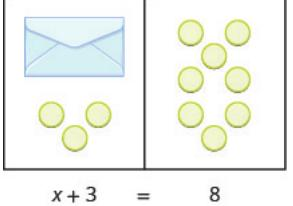


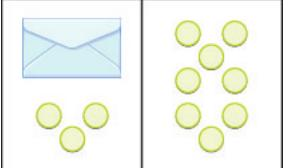


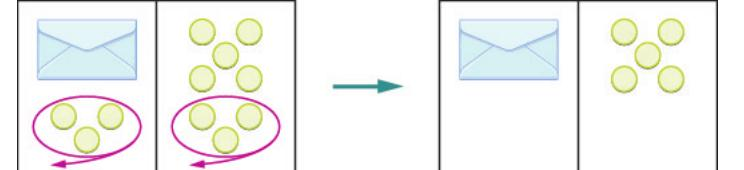

In [92]:
# Bring back images
plt_img_base64(docs[0])
plt_img_base64(docs[1])
plt_img_base64(docs[2])
plt_img_base64(docs[3])

## Running RAG pipeline

In [93]:
# Run RAG chain
query = "Explain to me how to solve equations using the subtraction and addition properties of equality"
chain_multimodal_rag.invoke(query)

"Great question! Let's walk through how to solve equations using the subtraction and addition properties of equality, using the example from the images.\n\n### Understanding the Model\n\n1. **Visual Representation**: \n   - The envelope represents the unknown variable, \\( x \\).\n   - Each counter represents the number 1.\n\n2. **Equation Setup**:\n   - On the left side, you have the envelope and 3 counters, which represents \\( x + 3 \\).\n   - On the right side, you have 8 counters, representing the number 8.\n\n### Solving the Equation\n\n1. **Equation**: \n   - You start with \\( x + 3 = 8 \\).\n\n2. **Using the Subtraction Property of Equality**:\n   - To isolate \\( x \\), you need to remove the 3 counters from the left side.\n   - Whatever you do to one side, you must do to the other to maintain balance.\n   - Subtract 3 from both sides: \n     \\[\n     x + 3 - 3 = 8 - 3\n     \\]\n\n3. **Simplify**:\n   - This leaves you with:\n     \\[\n     x = 5\n     \\]\n\n### Verificati